In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

C:\Users\REVANTH\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\REVANTH\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\REVANTH\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
with open("fb-pages-food.nodes",errors='ignore') as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges",errors='ignore') as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

We have 620 nodes and 2,102 links. Let’s now create a dataframe of all the nodes. Every row of this dataframe represents a link formed by the nodes in the columns ‘node_1’ and ‘node_2’, respectively:

In [4]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████████████████████████████████████████████████████| 2102/2102 [00:00<00:00, 526857.12it/s]


In [5]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


The nodes ‘276’, ’58’, ‘132’, ‘603’, and ‘398’ form links with the node ‘0’. We can easily represent this arrangement of Facebook pages in the form of a graph:

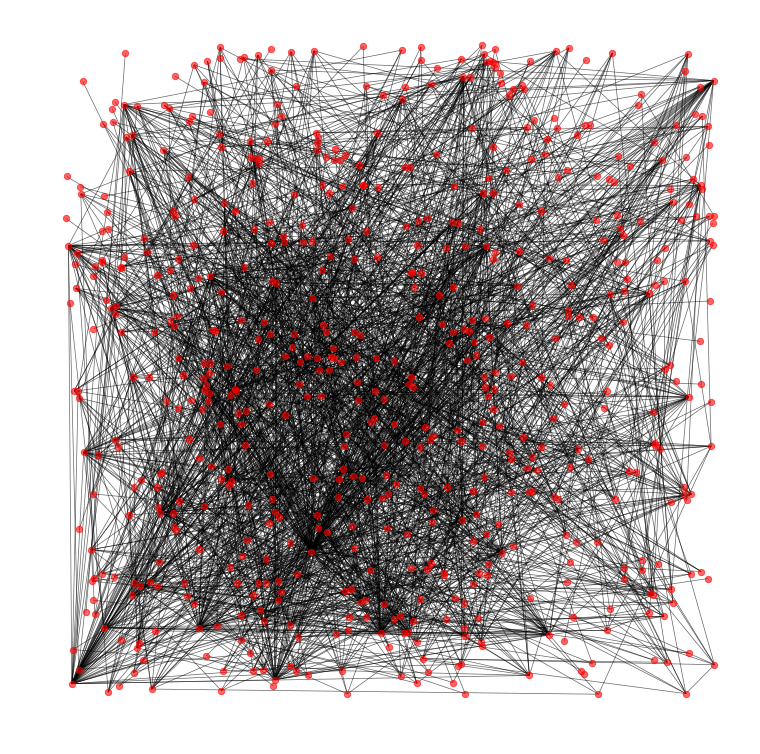

In [7]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

# Dataset Preparation for Model Building
We need to prepare the dataset from an undirected graph. This dataset will have features of node pairs and the target variable would be binary in nature, indicating the presence of links (or not).

## Retrieve Unconnected Node Pairs – Negative Samples

We have already understood that to solve a link prediction problem, we have to prepare a dataset from the given graph. A major part of this dataset is the negative samples or the unconnected node pairs.

First, we will create an adjacency matrix to find which pairs of nodes are not connected.

The links are denoted by the values in the matrix. 1 means there is a link between the node pair and 0 means there is a link between the node pair.We will use this property of the adjacency matrix to find all the unconnected node pairs from the original graph G:


In [8]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [9]:
#shape of adjacency matrix
adj_G.shape

(620, 620)

As you can see, it is a square matrix. Now, we will traverse the adjacency matrix to find the positions of the zeros.we don’t have to go through the entire matrix. The values in the matrix are the same above and below the diagonal.We can either search through the values above the diagonal (green part) or the values below (red part). Let’s search the diagonal values for zero:

In [10]:
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|████████████████████████████████████████████████████████████████| 620/620 [00:11<00:00, 54.30it/s]


In [11]:
#No of unconnected pairs in our graphs 
len(all_unconnected_pairs)

19018

We have 19,018 unconnected pairs. These node pairs will act as negative samples during the training of the link prediction model. we will keep these pairs in a dataframe:

In [12]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

## Remove Links from Connected Node Pairs – Positive Samples

To create a training set, we will randomly drop some of the edges from the graph. However, randomly removing edges may result in cutting off loosely connected nodes and fragments of the graph. This is something that we have to take care of. We have to make sure that in the process of dropping edges, all the nodes of the graph should remain connected.

In the code block below, we will first check if dropping a node pair results in the splitting of the graph (number_connected_components > 1) or reduction in the number of nodes. If both things do not happen, then we drop that node pair and repeat the same process with the next node pair.

Eventually, we will get a list of node pairs that can be dropped from the graph and all the nodes would still remain intact:

In [13]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|█████████████████████████████████████████████████████████████| 2102/2102 [00:12<00:00, 168.24it/s]


In [14]:
len(omissible_links_index)

1483

We have over 1400 links that we can drop from the graph. These dropped edges will act as positive training examples during the link prediction model training.

## Data for Model Training

Next, we will append these removable edges to the dataframe of unconnected node pairs. Since these new edges are positive samples, they will have a target value of ‘1’:

In [15]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [16]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

this is highly imbalanced data. The ratio of link vs no link is just close to 8%. In the next section, we will extract features for all these node pairs.

## Feature Extraction
We will use the node2vec algorithm to extract node features from the graph after dropping the links. So, let’s first create a new graph after dropping the removable links:

In [17]:
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

Next, we will install the node2vec library. It is quite similar to the DeepWalk algorithm. However, it involves biased random walks.
node2vec is used for vector representation of nodes of a graph.

In [18]:
!pip install node2vec

Now, we will train the node2vec model on our graph (G_data):

In [19]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|███████████████████████████████████████| 50/50 [00:22<00:00,  2.26it/s]


Next, we will apply the trained node2vec model on each and every node pair in the dataframe ‘data’. To compute the features of a pair or an edge, we will add up the features of the nodes in that pair:

In [20]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

C:\Users\REVANTH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


## Building our Link Prediction Model
To validate the performance of our model, we should split our data into two parts – one for training the model and the other to test the model’s performance:

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

Let’s fit a logistic regression model first:

In [23]:

lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

C:\Users\REVANTH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

We will now make predictions on the test set:

In [24]:
predictions = lr.predict_proba(xtest)


We will use the AUC-ROC score to check our model’s performance

In [25]:
roc_auc_score(ytest, predictions[:,1])

0.7999871493535297

We get a score of 0.80 using a logistic regression model. Let’s see if we can get a better score by using a more complex model.

lets try lightGBM

In [28]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[1]	valid_0's auc: 0.726048
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.771111
[3]	valid_0's auc: 0.782226
[4]	valid_0's auc: 0.803203
[5]	valid_0's auc: 0.809473
[6]	valid_0's auc: 0.817386
[7]	valid_0's auc: 0.823907
[8]	valid_0's auc: 0.828223
[9]	valid_0's auc: 0.833152
[10]	valid_0's auc: 0.836922
[11]	valid_0's auc: 0.841672
[12]	valid_0's auc: 0.84435
[13]	valid_0's auc: 0.846497
[14]	valid_0's auc: 0.85046
[15]	valid_0's auc: 0.852773
[16]	valid_0's auc: 0.855825
[17]	valid_0's auc: 0.857832
[18]	valid_0's auc: 0.859996
[19]	valid_0's auc: 0.862562
[20]	valid_0's auc: 0.863948
[21]	valid_0's auc: 0.868078
[22]	valid_0's auc: 0.872006
[23]	valid_0's auc: 0.875941
[24]	valid_0's auc: 0.877067
[25]	valid_0's auc: 0.879684
[26]	valid_0's auc: 0.88161
[27]	valid_0's auc: 0.882339
[28]	valid_0's auc: 0.88379
[29]	valid_0's auc: 0.883822
[30]	valid_0's auc: 0.885075
[31]	valid_0's auc: 0.886075
[32]	valid_0's auc: 0.886686
[33]	valid_0's auc: 0.88

The training stopped after the 226th iteration because we applied the early stopping criteria. Most importantly, the model got an impressive 0.9235 AUC score on the test set.